In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
from tqdm import tqdm
import pickle
tqdm.pandas()
import warnings
import catboost as cb
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import r2_score
from submission_xgboost.utils import *
from sklearn.metrics import r2_score

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Initial position and dict of Omni

In [3]:
initial_states = pd.read_csv('C:/Users/isaac/Documents/Challenge_MIT_2/mit_challenge_2/data/phase_1/00000_to_02284-initial_states.csv')
initial_states = pd.concat([initial_states,pd.read_csv('C:/Users/isaac/Documents/Challenge_MIT_2/mit_challenge_2/data/phase_1/02285_to_02357-initial_states.csv')])
initial_states = pd.concat([initial_states,pd.read_csv('C:/Users/isaac/Documents/Challenge_MIT_2/mit_challenge_2/data/phase_1/02358_to_04264-initial_states.csv')])
initial_states = pd.concat([initial_states,pd.read_csv('C:/Users/isaac/Documents/Challenge_MIT_2/mit_challenge_2/data/phase_1/04265_to_05570-initial_states.csv')])
initial_states = pd.concat([initial_states,pd.read_csv('C:/Users/isaac/Documents/Challenge_MIT_2/mit_challenge_2/data/phase_1/05571_to_05614-initial_states.csv')])
initial_states = pd.concat([initial_states,pd.read_csv('C:/Users/isaac/Documents/Challenge_MIT_2/mit_challenge_2/data/phase_1/05615_to_06671-initial_states.csv')])
initial_states = pd.concat([initial_states,pd.read_csv('C:/Users/isaac/Documents/Challenge_MIT_2/mit_challenge_2/data/phase_1/06672_to_08118-initial_states.csv')])
initial_states['Timestamp'] = pd.to_datetime(initial_states['Timestamp'])

# add last data
#df_temp = pd.read_csv('C:/Users/isaac/Documents/Challenge_MIT_2/mit_challenge_2/data/phase_1/06672_to_08118-initial_states.csv')
# df_temp['Timestamp'] = pd.to_datetime(df_temp['Timestamp'])
# initial_states = pd.concat([initial_states,df_temp])
initial_states = initial_states.set_index('File ID')
print(initial_states.shape)
initial_states =  initial_states.mask((initial_states==9.99e+29)|(initial_states==9.99e+32))
initial_states = initial_states.loc[initial_states.count(1)==10]
print(initial_states.shape)

(8119, 10)
(8095, 10)


### Estimates lat, long, alt

In [15]:
model_alt = cb.CatBoostRegressor(loss_function='RMSE',iterations=100,subsample=0.7)
model_alt.fit(X=initial_states.dropna()[['Semi-major Axis (km)',	'Eccentricity',	'Inclination (deg)',	'RAAN (deg)',	'Argument of Perigee (deg)',	'True Anomaly (deg)']],
              y= initial_states.dropna()['Altitude (km)'])

Learning rate set to 0.370406
0:	learn: 34.0849117	total: 149ms	remaining: 14.7s
1:	learn: 23.4140598	total: 151ms	remaining: 7.4s
2:	learn: 17.1407188	total: 153ms	remaining: 4.95s
3:	learn: 13.3577659	total: 155ms	remaining: 3.72s
4:	learn: 11.0353106	total: 157ms	remaining: 2.98s
5:	learn: 9.4853877	total: 159ms	remaining: 2.49s
6:	learn: 8.4717434	total: 161ms	remaining: 2.14s
7:	learn: 7.8482870	total: 163ms	remaining: 1.87s
8:	learn: 7.3961932	total: 165ms	remaining: 1.67s
9:	learn: 6.9942745	total: 167ms	remaining: 1.5s
10:	learn: 6.7818579	total: 169ms	remaining: 1.37s
11:	learn: 6.3432045	total: 171ms	remaining: 1.25s
12:	learn: 6.1187997	total: 173ms	remaining: 1.16s
13:	learn: 5.9106440	total: 175ms	remaining: 1.07s
14:	learn: 5.6089736	total: 177ms	remaining: 1s
15:	learn: 5.4483026	total: 179ms	remaining: 938ms
16:	learn: 5.1319984	total: 181ms	remaining: 882ms
17:	learn: 5.0640790	total: 183ms	remaining: 832ms
18:	learn: 5.0082886	total: 185ms	remaining: 787ms
19:	learn: 

In [16]:
initial_states['Altitude (km) estimated'] = model_alt.predict(initial_states[['Semi-major Axis (km)',	'Eccentricity',	'Inclination (deg)',	'RAAN (deg)',	'Argument of Perigee (deg)',	'True Anomaly (deg)']])

In [ ]:
model_lat = cb.CatBoostRegressor(loss_function='RMSE',iterations=100,subsample=0.8,depth=2)
model_lat.fit(X=initial_states.dropna()[['Semi-major Axis (km)',	'Eccentricity',	'Inclination (deg)',	'RAAN (deg)',	'Argument of Perigee (deg)',	'True Anomaly (deg)']],
              y= initial_states.dropna()['Latitude (deg)'])

In [ ]:
model_long = cb.CatBoostRegressor(loss_function='RMSE',iterations=100,depth=2)
model_long.fit(X=initial_states.dropna()[['Semi-major Axis (km)',	'Eccentricity',	'Inclination (deg)',	'RAAN (deg)',	'Argument of Perigee (deg)',	'True Anomaly (deg)']].iloc[:4000],
              y= initial_states.dropna()['Longitude (deg)'].iloc[:4000])

print(model_long.score(X=initial_states.dropna()[['Semi-major Axis (km)',	'Eccentricity',	'Inclination (deg)',	'RAAN (deg)',	'Argument of Perigee (deg)',	'True Anomaly (deg)']].iloc[:4000],
              y= initial_states.dropna()['Longitude (deg)'].iloc[:4000]))

print(model_long.score(X=initial_states.dropna()[['Semi-major Axis (km)',	'Eccentricity',	'Inclination (deg)',	'RAAN (deg)',	'Argument of Perigee (deg)',	'True Anomaly (deg)']].iloc[4000:],
              y= initial_states.dropna()['Longitude (deg)'].iloc[4000:]))

### Read data

In [ ]:
# all_files_omni = os.listdir("phase_1/omni2/")
# all_files_dens = os.listdir("phase_1/sat_density/")
# omni = {}
# for i in tqdm(all_files_omni):
#     omni[int(i.split('-')[1])] = pd.read_csv('phase_1/omni2/'+i)
# sat = {}
# for i in tqdm(all_files_dens):
#     sat[int(i.replace('gr-of','grof').split('-')[1])] = pd.read_csv('phase_1/sat_density/'+i)
# with open('omni.pickle', 'wb') as handle:
#     pickle.dump(omni, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('sat.pickle', 'wb') as handle:
#     pickle.dump(sat, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [4]:
with open('data/data_isaac/omni.pickle', 'rb') as f:
    omni = pickle.load(f)
with open('data/data_isaac/sat.pickle', 'rb') as f:
    sat = pickle.load(f)

for i in sat.keys():
    sat[i]['Orbit Mean Density (kg/m^3)'] = sat[i]['Orbit Mean Density (kg/m^3)'].replace(9.99e32, np.nan)
    sat[i]['Orbit Mean Density (kg/m^3)'] = sat[i]['Orbit Mean Density (kg/m^3)'].ffill().bfill() # add forward and backward fill

### Compute R2 with mean and median

In [11]:
all_sat = pd.concat(sat,keys=sat.keys())
all_sat = all_sat.reset_index().drop(['level_1'],axis=1).rename({'level_0':'File Id'},axis=1)
df_mean = all_sat.groupby('File Id')['Orbit Mean Density (kg/m^3)'].mean()
df_median = all_sat.groupby('File Id')['Orbit Mean Density (kg/m^3)'].median()
all_sat = pd.merge_ordered(all_sat,df_mean,on='File Id',suffixes=['','_mean'])
all_sat = pd.merge_ordered(all_sat,df_median,on='File Id',suffixes=['','_median'])

In [14]:
r2_score(all_sat.dropna()['Orbit Mean Density (kg/m^3)'], all_sat.dropna()['Orbit Mean Density (kg/m^3)_mean'])

0.9812099283983322

In [15]:
r2_score(all_sat.dropna()['Orbit Mean Density (kg/m^3)'], all_sat.dropna()['Orbit Mean Density (kg/m^3)_median'])

0.9788036530241374

<Axes: >

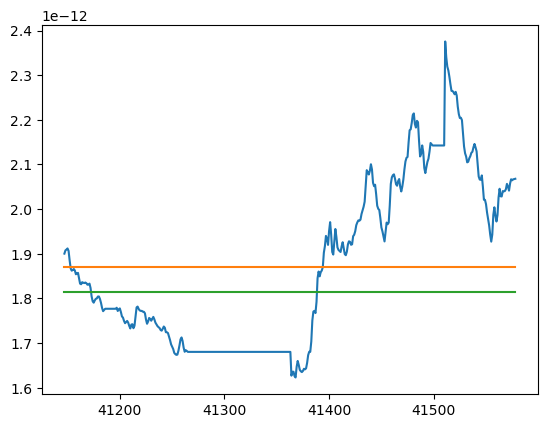

In [80]:
id = 100
all_sat['Orbit Mean Density (kg/m^3)'].loc[all_sat['File Id']==id].plot()
all_sat['Orbit Mean Density (kg/m^3)_mean'].loc[all_sat['File Id']==id].plot()
all_sat['Orbit Mean Density (kg/m^3)_median'].loc[all_sat['File Id']==id].plot()

### See features

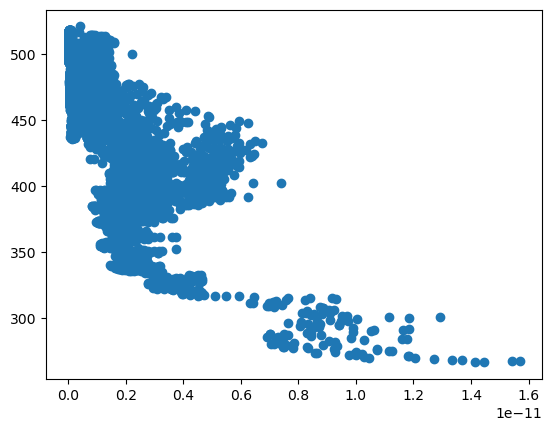

In [23]:
plt.scatter(df_data['Target'],df_data['Altitude (km)'])

<Axes: >

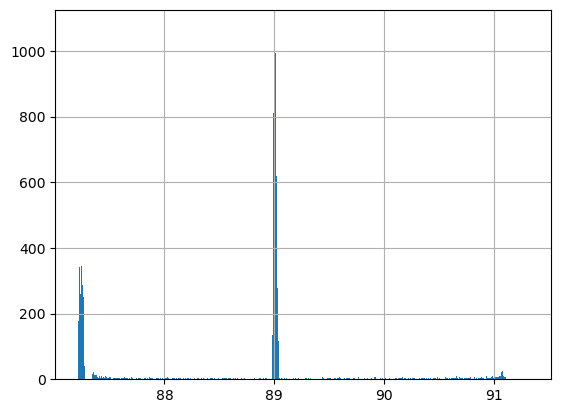

In [24]:
df_data['Inclination (deg)'].hist(bins=500)

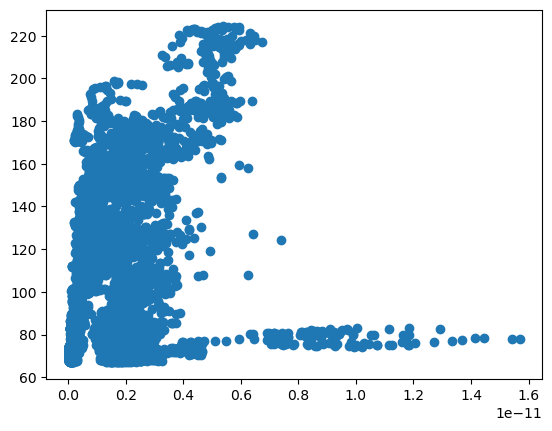

In [25]:
plt.scatter(df_data['Target'],df_data['mean_f10.7_index'])

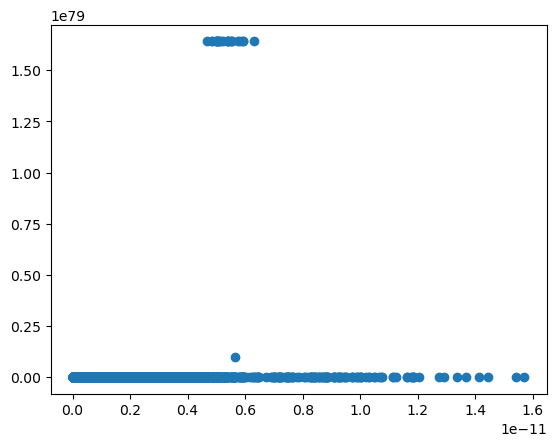

In [26]:
plt.scatter(df_data['Target'],np.exp(df_data['min_f10.7_index']))

In [27]:
df_data.corr()['Target'].abs().sort_values(ascending=False).head(50)

Target                              1.000000
Altitude (km)                       0.728242
Semi-major Axis (km)                0.651317
Inclination (deg)                   0.561894
Latitude (deg)                      0.483362
File Id                             0.468361
min_f10.7_index                     0.423227
last_Lyman_alpha                    0.406989
mean_Flow_pressure                  0.401218
mean_Quasy_Invariant                0.399840
mean_f10.7_index                    0.397837
mean_sigma_n_N_cm3                  0.396971
min_Lyman_alpha                     0.396656
mean_SW_Proton_Density_N_cm3        0.395784
min_R_Sunspot_No                    0.392049
mean_Plasma_Beta                    0.391018
min_Bartels_rotation_number         0.388780
max_Bartels_rotation_number         0.388727
last_Bartels_rotation_number        0.388727
mean_Bartels_rotation_number        0.388722
Timestamp_initial                   0.388719
mean_Alfen_mach_number              0.388165
min_YEAR  

### Prepare by timestamps

In [22]:
# res = initial_states.reset_index()['File ID'].progress_apply(lambda win:create_features_and_target(win,initial_states,omni,sat,predict_mean=False,training_mode=True))
# with open('data/data_isaac/res_6000.pickle', 'wb') as handle:
#      pickle.dump(res, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('data/data_isaac/res_6000.pickle', 'rb') as f:
    res = pickle.load(f)

### Prepare by mean

In [ ]:
res = {}
for i in tqdm(initial_states.index):
    res[i] = create_features_and_target(i,initial_states,omni = omni[i],sat = sat[i],predict_mean=True,training_mode=True)

C:\Users\isaac\miniconda3\envs\small_env_2\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\isaac\miniconda3\envs\small_env_2\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\isaac\miniconda3\envs\small_env_2\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\isaac\miniconda3\envs\small_env_2\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\isaac\miniconda3\envs\small_env_2\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\isaac\miniconda3\envs\small_env_2\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= st

In [12]:
df_data = pd.concat(res,axis=0)

In [13]:
df_data

YEAR_min  YEAR_max  YEAR_mean  YEAR_median  YEAR_std  YEAR_var  \
0    0    2000.0    2000.0     2000.0       2000.0       0.0       0.0   
1    0    2000.0    2000.0     2000.0       2000.0       0.0       0.0   
2    0    2000.0    2000.0     2000.0       2000.0       0.0       0.0   
3    0    2000.0    2000.0     2000.0       2000.0       0.0       0.0   
4    0    2000.0    2000.0     2000.0       2000.0       0.0       0.0   
...          ...       ...        ...          ...       ...       ...   
8114 0    2019.0    2019.0     2019.0       2019.0       0.0       0.0   
8115 0    2019.0    2019.0     2019.0       2019.0       0.0       0.0   
8116 0    2019.0    2019.0     2019.0       2019.0       0.0       0.0   
8117 0    2019.0    2019.0     2019.0       2019.0       0.0       0.0   
8118 0    2019.0    2019.0     2019.0       2019.0       0.0       0.0   

        YEAR_last  YEAR_range   YEAR_sum  YEAR_skew  ...  \
0    0     2000.0         0.0  2880000.0        0.0  ...   
1    0     2000.0         0.0  2880000.0        0.0  ...   
2    0     2000.0         0.0  2880000.0        0.0  ...   
3    0     2000.0         0.0  2880000.0        0.0  ...   
4    0     2000.0         0.0  2880000.0        0.0  ...   
...           ...         ...        ...        ...  ...   
8114 0     2019.0         0.0  2909379.0        0.0  ...   
8115 0     2019.0         0.0  2909379.0        0.0  ...   
8116 0     2019.0         0.0  2909379.0        0.0  ...   
8117 0     2019.0         0.0  2909379.0        0.0  ...   
8118 0     2019.0         0.0  2909379.0        0.0  ...   

        Semi-major Axis (km)  Eccentricity  Inclination (deg)  RAAN (deg)  \
0    0           6826.387247      0.003882          87.275306  144.135111   
1    0           6826.327748      0.003879          87.275694  143.529694   
2    0           6819.634802      0.004114          87.268611  142.972111   
3    0           6819.606603      0.004134          87.268194  142.608389   
4    0           6819.425918      0.004178          87.264611  141.605111   
...                      ...           ...                ...         ...   
8114 0           6765.013678      0.005730          87.863978  102.587920   
8115 0           6801.130577      0.002172          90.690901   99.760357   
8116 0           6805.864837      0.001925          91.053632   96.918243   
8117 0           6774.300973      0.004785          88.598951   92.814340   
8118 0           6760.271184      0.008966          87.482347   92.552352   

        Argument of Perigee (deg)  True Anomaly (deg)  Latitude (deg)  \
0    0                 257.314389          102.383270       43.637815   
1    0                 250.438806          109.273118       43.444458   
2    0                 244.549389          115.138737       19.764250   
3    0                 241.172000          118.545161       12.450738   
4    0                 228.779611          130.982981       -8.776992   
...                           ...                 ...             ...   
8114 0                 240.608198          187.758342       69.535173   
8115 0                 152.602156          226.350702       20.225336   
8116 0                  43.442569          131.160787        4.265831   
8117 0                 320.652681          164.621884       53.716936   
8118 0                  99.694995          180.772065      -78.188032   

        Longitude (deg)  Altitude (km)        Target  
0    0       -62.543128     466.448890  1.595720e-12  
1    0        70.139709     463.435053  1.725942e-12  
2    0       104.521278     471.625453  1.717353e-12  
3    0       112.239558     470.385914  1.664704e-12  
4    0      -130.559634     468.911226  2.169837e-12  
...                 ...            ...           ...  
8114 0       108.291937     443.930606  1.340804e-13  
8115 0        99.507926     435.492910  1.297873e-13  
8116 0       -83.003782     436.652863  1.272349e-13  
8117 0       -89.084995     441.438958  1.3055

In [28]:
df_data['Log_lat'] = np.log(df_data['Latitude (deg)'])
df_data['Exp_lat'] = np.exp(df_data['Latitude (deg)'])

C:\Users\isaac\miniconda3\envs\small_env_2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## XGBOOST

In [29]:
len(res)

8095

### Prediction by mean

In [14]:
index = list(res.keys())
np.random.seed(24)
np.random.shuffle(index)

In [15]:
train_index,valid_index,test_index = index[4000:4600],index[4600:5900],index[5900:]
col_to_remove = ['File Id','Timestamp_initial'] +\
                [i for i in res[0].columns if i.find('YEAR')!=-1]+\
                [i for i in res[0].columns if i.find('DOY')!=-1]+\
                [i for i in res[0].columns if i.find('Hour')!=-1]+\
                [i for i in res[0].columns if i.find('std_')!=-1]+\
                [i for i in res[0].columns if i.find('median_')!=-1]
                #[i for i in res[0].columns if i.find('mean_')!=-1]+\
                #[i for i in res[0].columns if i.find('max_')!=-1]+\
                #[i for i in res[0].columns if i.find('min_')!=-1]+\
print(len(col_to_remove))

140


#### All train

In [34]:
df_training_set_all = df_data.set_index('File Id').loc[list( set(initial_states.index))].reset_index()
df_training_set_all = df_training_set_all.drop(col_to_remove,axis=1)
df_training_set_all = df_training_set_all.dropna(subset='Target')
train_dataset_all = cb.Pool(df_training_set_all.drop('Target',axis=1), df_training_set_all['Target']* 10**12) 

In [57]:
model_mean = cb.CatBoostRegressor(loss_function='RMSE',iterations=7000)
model_mean.fit(train_dataset_all)

Learning rate set to 0.011709
0:	learn: 1.5322858	total: 17.4ms	remaining: 2m 1s
1:	learn: 1.5173497	total: 28.5ms	remaining: 1m 39s
2:	learn: 1.5031290	total: 40.1ms	remaining: 1m 33s
3:	learn: 1.4887136	total: 51ms	remaining: 1m 29s
4:	learn: 1.4748169	total: 61.5ms	remaining: 1m 26s
5:	learn: 1.4607156	total: 72.1ms	remaining: 1m 24s
6:	learn: 1.4474823	total: 82.2ms	remaining: 1m 22s
7:	learn: 1.4337818	total: 92.2ms	remaining: 1m 20s
8:	learn: 1.4200449	total: 102ms	remaining: 1m 19s
9:	learn: 1.4065135	total: 113ms	remaining: 1m 18s
10:	learn: 1.3927330	total: 122ms	remaining: 1m 17s
11:	learn: 1.3799111	total: 133ms	remaining: 1m 17s
12:	learn: 1.3672994	total: 144ms	remaining: 1m 17s
13:	learn: 1.3550332	total: 155ms	remaining: 1m 17s
14:	learn: 1.3422398	total: 167ms	remaining: 1m 17s
15:	learn: 1.3295617	total: 178ms	remaining: 1m 17s
16:	learn: 1.3176097	total: 189ms	remaining: 1m 17s
17:	learn: 1.3053177	total: 202ms	remaining: 1m 18s
18:	learn: 1.2933016	total: 215ms	remai

In [58]:
model_mean.save_model('data/trained_model/model_by_mean_xgboost_3.cbm')

#### Cut

In [16]:
df_training_set = df_data.set_index('File Id').loc[list(set(train_index) & set(initial_states.index))].reset_index()
df_training_set = df_training_set.drop(col_to_remove,axis=1)
df_training_set = df_training_set.dropna(subset='Target')


df_valid_set = df_data.set_index('File Id').loc[list(set(valid_index) & set(initial_states.index))].reset_index()
df_valid_set = df_valid_set.drop(col_to_remove,axis=1)
df_valid_set = df_valid_set.dropna(subset='Target')

df_test_set = df_data.set_index('File Id').loc[list(set(test_index) & set(initial_states.index))].reset_index()
df_test_set = df_test_set.drop(col_to_remove,axis=1)
df_test_set = df_test_set.dropna(subset='Target')


train_dataset = cb.Pool(df_training_set.drop('Target',axis=1), df_training_set['Target']* 10**12) 
valid_dataset = cb.Pool(df_valid_set.drop('Target',axis=1), df_valid_set['Target']* 10**12) 
test_dataset = cb.Pool(df_test_set.drop('Target',axis=1), df_test_set['Target']* 10**12) 

In [23]:
model_mean = cb.CatBoostRegressor(loss_function='RMSE',iterations=10000)
model_mean.fit(train_dataset,eval_set=valid_dataset)

Learning rate set to 0.011536
0:	learn: 1.5553133	test: 1.5752822	best: 1.5752822 (0)	total: 65.4ms	remaining: 10m 53s
1:	learn: 1.5457113	test: 1.5671736	best: 1.5671736 (1)	total: 120ms	remaining: 9m 57s
2:	learn: 1.5354958	test: 1.5561627	best: 1.5561627 (2)	total: 175ms	remaining: 9m 44s
3:	learn: 1.5262635	test: 1.5478475	best: 1.5478475 (3)	total: 232ms	remaining: 9m 39s
4:	learn: 1.5151694	test: 1.5357794	best: 1.5357794 (4)	total: 289ms	remaining: 9m 38s
5:	learn: 1.5048101	test: 1.5272872	best: 1.5272872 (5)	total: 344ms	remaining: 9m 32s
6:	learn: 1.4942232	test: 1.5184603	best: 1.5184603 (6)	total: 397ms	remaining: 9m 27s
7:	learn: 1.4835958	test: 1.5071645	best: 1.5071645 (7)	total: 449ms	remaining: 9m 21s
8:	learn: 1.4739976	test: 1.4976903	best: 1.4976903 (8)	total: 506ms	remaining: 9m 22s
9:	learn: 1.4636981	test: 1.4893094	best: 1.4893094 (9)	total: 561ms	remaining: 9m 20s
10:	learn: 1.4536113	test: 1.4792050	best: 1.4792050 (10)	total: 613ms	remaining: 9m 16s
11:	learn

In [24]:
print(model_mean.score(train_dataset))
print(model_mean.score(valid_dataset))
print(model_mean.score(test_dataset))

0.9999999988077892
0.9262489329167085
0.9273466523145028


In [25]:
data = pd.DataFrame({'feature_importance':model_mean.get_feature_importance(), 
              'feature_names': model_mean.feature_names_}).sort_values(by=['feature_importance'], 
                                                       ascending=False)
data.head(15)

feature_importance                               feature_names
1412           30.058118                               Altitude (km)
1406           15.256178                           Inclination (deg)
1404           14.330096                        Semi-major Axis (km)
1410            3.334972                              Latitude (deg)
1405            1.323042                                Eccentricity
1202            1.163728                            Lyman_alpha_last
1072            0.993866                            f10.7_index_last
12              0.674786     Bartels_rotation_number_75th_percentile
994             0.595004                           R_Sunspot_No_last
3               0.589409              Bartels_rotation_number_median
6               0.540790                Bartels_rotation_number_last
25              0.516953  Bartels_rotation_number_max_rolling_mean_7
11              0.413438     Bartels_rotation_number_25th_percentile
54              0.358369            ID_for_SW_Plasma_spacecraft_mean
1197            0.345205                             Lyman_alpha_max

In [78]:
model_mean = cb.CatBoostRegressor(iterations=100)
grid = {'subsample': [ 0.8, 0.9],
        'depth': [2,4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
       }
grid_search_result  = model_mean.grid_search(grid, X = train_dataset_all)

0:	learn: 2.0581287	test: 1.9876477	best: 1.9876477 (0)	total: 2.3ms	remaining: 228ms
1:	learn: 2.0078919	test: 1.9382444	best: 1.9382444 (1)	total: 4.75ms	remaining: 233ms
2:	learn: 1.9586558	test: 1.8897296	best: 1.8897296 (2)	total: 6.71ms	remaining: 217ms
3:	learn: 1.9104499	test: 1.8439047	best: 1.8439047 (3)	total: 8.65ms	remaining: 208ms
4:	learn: 1.8650325	test: 1.8010750	best: 1.8010750 (4)	total: 10.5ms	remaining: 200ms
5:	learn: 1.8205871	test: 1.7573460	best: 1.7573460 (5)	total: 12.4ms	remaining: 195ms
6:	learn: 1.7781404	test: 1.7151166	best: 1.7151166 (6)	total: 14.4ms	remaining: 191ms
7:	learn: 1.7356447	test: 1.6734896	best: 1.6734896 (7)	total: 16.3ms	remaining: 187ms
8:	learn: 1.6954706	test: 1.6338910	best: 1.6338910 (8)	total: 18.2ms	remaining: 184ms
9:	learn: 1.6561399	test: 1.5968657	best: 1.5968657 (9)	total: 20.1ms	remaining: 181ms
10:	learn: 1.6179572	test: 1.5608498	best: 1.5608498 (10)	total: 22.5ms	remaining: 182ms
11:	learn: 1.5824656	test: 1.5261920	best:

KeyboardInterrupt: 

In [31]:
model_mean.save_model('data/trained_model/model_by_mean_xgboost.cbm')

### Prediction by timestamp to predict

#### Test train validate

In [7]:
index = list(res.keys())
np.random.seed(24)
np.random.shuffle(index)

In [ ]:
#train_index,valid_index,test_index = index[:5600],index[5600:6900],index[6900:]

In [9]:
train_index,valid_index,test_index = index[4000:4600],index[4600:5900],index[5900:]
col_to_remove = ['FileId','Timestamp','Timestamp_initial'] +\
                [i for i in res[0].columns if i.find('YEAR')!=-1]+\
                [i for i in res[0].columns if i.find('DOY')!=-1]+\
                [i for i in res[0].columns if i.find('Hour')!=-1]+\
                [i for i in res[0].columns if i.find('std_')!=-1]+\
                [i for i in res[0].columns if i.find('median_')!=-1]
                #[i for i in res[0].columns if i.find('mean_')!=-1]+\
                #[i for i in res[0].columns if i.find('max_')!=-1]+\
                #[i for i in res[0].columns if i.find('min_')!=-1]+\
print(len(col_to_remove))

15


In [11]:
df_training_set = pd.concat( dict((k,res[k]) for k in train_index if k in initial_states.index)).reset_index().rename({'level_0':'FileId'},axis=1)
df_training_set = df_training_set.drop(col_to_remove,axis=1)
df_training_set = df_training_set.dropna(subset=['Orbit Mean Density (kg/m^3)'],axis=0)

df_valid_set =  pd.concat( dict((k,res[k]) for k in valid_index if k in initial_states.index)).reset_index().rename({'level_0':'FileId'},axis=1)
df_valid_set = df_valid_set.drop(col_to_remove,axis=1)
df_valid_set = df_valid_set.dropna(subset=['Orbit Mean Density (kg/m^3)'],axis=0)

df_test_set =  pd.concat( dict((k,res[k]) for k in test_index if k in initial_states.index)).reset_index().rename({'level_0':'FileId'},axis=1)
df_test_set = df_test_set.drop(col_to_remove,axis=1)
df_test_set = df_test_set.dropna(subset=['Orbit Mean Density (kg/m^3)'],axis=0)

train_dataset = cb.Pool(df_training_set.drop('Orbit Mean Density (kg/m^3)',axis=1), df_training_set['Orbit Mean Density (kg/m^3)']* 10**12) 
valid_dataset = cb.Pool(df_valid_set.drop('Orbit Mean Density (kg/m^3)',axis=1), df_valid_set['Orbit Mean Density (kg/m^3)']* 10**12) 
test_dataset = cb.Pool(df_test_set.drop('Orbit Mean Density (kg/m^3)',axis=1), df_test_set['Orbit Mean Density (kg/m^3)']* 10**12) 

In [12]:
print(df_training_set.shape)
print(df_valid_set.shape)
print(df_test_set.shape)

(251714, 227)
(545317, 227)
(312511, 227)


#### All 

In [18]:
df_training_set = pd.concat(res.values).reset_index()

df_training_set = df_training_set.reset_index().rename({'index':'FileId'},axis=1)
df_training_set = df_training_set.drop(col_to_remove,axis=1)
df_training_set = df_training_set.dropna(subset=['Orbit Mean Density (kg/m^3)'],axis=0)

train_dataset = cb.Pool(df_training_set.drop('Orbit Mean Density (kg/m^3)',axis=1), df_training_set['Orbit Mean Density (kg/m^3)']* 10**12) 

In [22]:
model = cb.CatBoostRegressor(loss_function='RMSE',iterations=360,depth=6,eta=0.2,subsample=0.9,l2_leaf_reg=1)
model.fit(train_dataset)

0:	learn: 1.3879176	total: 1.19s	remaining: 7m 8s
1:	learn: 1.1532201	total: 2.17s	remaining: 6m 27s
2:	learn: 0.9698697	total: 2.76s	remaining: 5m 28s
3:	learn: 0.8284156	total: 3.5s	remaining: 5m 11s
4:	learn: 0.7150822	total: 4.39s	remaining: 5m 11s
5:	learn: 0.6298567	total: 5.15s	remaining: 5m 3s
6:	learn: 0.5634896	total: 5.85s	remaining: 4m 54s
7:	learn: 0.5143894	total: 6.53s	remaining: 4m 47s
8:	learn: 0.4769476	total: 7.16s	remaining: 4m 39s
9:	learn: 0.4477845	total: 7.72s	remaining: 4m 30s
10:	learn: 0.4262590	total: 8.34s	remaining: 4m 24s
11:	learn: 0.4086139	total: 9.03s	remaining: 4m 21s
12:	learn: 0.3939127	total: 9.61s	remaining: 4m 16s
13:	learn: 0.3823580	total: 10.2s	remaining: 4m 11s
14:	learn: 0.3734000	total: 10.8s	remaining: 4m 8s
15:	learn: 0.3649466	total: 11.5s	remaining: 4m 7s
16:	learn: 0.3594169	total: 12.1s	remaining: 4m 4s
17:	learn: 0.3533351	total: 12.7s	remaining: 4m 1s
18:	learn: 0.3481757	total: 13.4s	remaining: 4m
19:	learn: 0.3439340	total: 13.9s

In [25]:
data = pd.DataFrame({'feature_importance':model.get_feature_importance(), 
              'feature_names': model.feature_names_}).sort_values(by=['feature_importance'], 
                                                       ascending=False)
data.head(15)

feature_importance              feature_names
216           43.397659       Semi-major Axis (km)
222           15.117687             Latitude (deg)
224           14.176859              Altitude (km)
203            3.172057           last_f10.7_index
208            3.147283           last_Lyman_alpha
149            2.707727            min_f10.7_index
160            1.995492    min_Proton_flux_>60_Mev
46             1.387590           mean_Lyman_alpha
81             1.253690           max_sigma_V_km_s
82             0.853258    max_sigma_phi_V_degrees
153            0.741087               min_pc_index
150            0.703149            min_AE_index_nT
37             0.650394              mean_Kp_index
52             0.650235   mean_Proton_flux_>60_Mev
114            0.620943  min_Vector_B_Magnitude_nT

In [23]:
print(model.score(train_dataset))

0.98097112972462


In [24]:
model.save_model('data/trained_model/model_by_timestamp_xgboost_optimized_parameters_2.cbm')

#### Train model

In [ ]:
model = cb.CatBoostRegressor(iterations=100)
grid = {'subsample': [ 0.8, 0.9],
        'depth': [2,4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
       }
grid_search_result  = model.grid_search(grid, X = train_dataset)

In [13]:
model = cb.CatBoostRegressor(loss_function='RMSE',iterations=260,depth=2,eta=0.2,subsample=0.9,l2_leaf_reg=1)
model.fit(train_dataset,eval_set=valid_dataset)

0:	learn: 1.3144539	test: 1.4785929	best: 1.4785929 (0)	total: 200ms	remaining: 51.8s
1:	learn: 1.1595323	test: 1.2846583	best: 1.2846583 (1)	total: 240ms	remaining: 31s
2:	learn: 1.0391116	test: 1.1754748	best: 1.1754748 (2)	total: 280ms	remaining: 24s
3:	learn: 0.9438533	test: 1.0416093	best: 1.0416093 (3)	total: 318ms	remaining: 20.3s
4:	learn: 0.8684892	test: 0.9733902	best: 0.9733902 (4)	total: 353ms	remaining: 18s
5:	learn: 0.7941500	test: 0.8870395	best: 0.8870395 (5)	total: 380ms	remaining: 16.1s
6:	learn: 0.7379757	test: 0.8232711	best: 0.8232711 (6)	total: 419ms	remaining: 15.1s
7:	learn: 0.6854936	test: 0.7580833	best: 0.7580833 (7)	total: 453ms	remaining: 14.3s
8:	learn: 0.6412267	test: 0.7122316	best: 0.7122316 (8)	total: 484ms	remaining: 13.5s
9:	learn: 0.6066006	test: 0.6828976	best: 0.6828976 (9)	total: 520ms	remaining: 13s
10:	learn: 0.5761902	test: 0.6434307	best: 0.6434307 (10)	total: 550ms	remaining: 12.5s
11:	learn: 0.5527491	test: 0.6249826	best: 0.6249826 (11)	to

In [14]:
print(model.score(train_dataset))
print(model.score(valid_dataset))
print(model.score(test_dataset))

0.9764542218868594
0.923263158845603
0.9174713806367963


<Axes: >

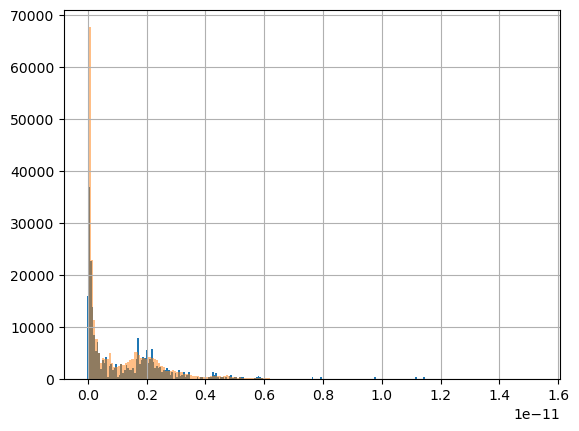

In [15]:
plt.hist(model.predict(train_dataset)/10**12,bins=200)
df_training_set['Orbit Mean Density (kg/m^3)'].hist(bins=200,alpha=0.5)

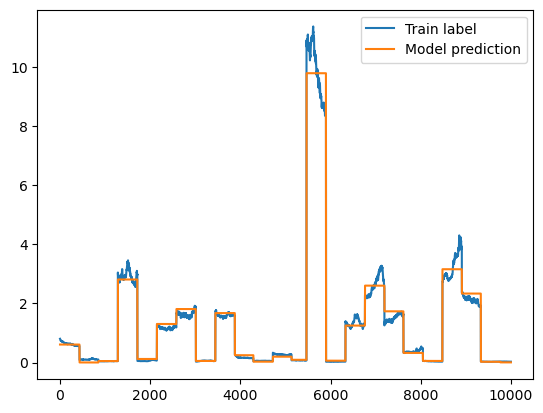

In [16]:
pd.DataFrame(train_dataset.get_label()).iloc[:10000:,0].plot(label='Train label')
pd.DataFrame(model.predict(train_dataset)).iloc[:10000,0].plot(label='Model prediction')
plt.legend()

In [17]:
data = pd.DataFrame({'feature_importance':model.get_feature_importance(), 
                     'feature_names': model.feature_names_}).sort_values(by=['feature_importance'], 
                                                       ascending=False) 
data.head(20)

feature_importance                  feature_names
216           43.084024           Semi-major Axis (km)
224           22.806840                  Altitude (km)
208            8.858090               last_Lyman_alpha
222            6.401833                 Latitude (deg)
203            3.123193               last_f10.7_index
218            3.008515              Inclination (deg)
100            2.457342                max_Lyman_alpha
18             1.053163             mean_RMS_BZ_GSE_nT
36             0.865909           mean_Quasy_Invariant
201            0.726064              last_Dst_index_nT
40             0.599275               mean_ap_index_nT
193            0.495063             last_Flow_pressure
167            0.482235               last_Scalar_B_nT
13             0.375587                 mean_BZ_nT_GSM
130            0.299421  min_SW_Plasma_flow_long_angle
185            0.258759  last_SW_Plasma_flow_lat_angle
168            0.244284     last_Vector_B_Magnitude_nT
3              0.244174   mean_num_points_IMF_averages
153            0.222121                   min_pc_index
200            0.202141              last_R_Sunspot_No

In [ ]:
model.save_model('data/trained_model/model_by_timestamp_xgboost_second.cbm')

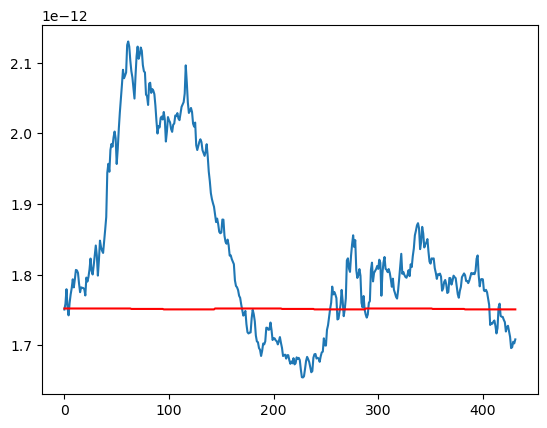

In [25]:
id = 101
res[id].reset_index()['Orbit Mean Density (kg/m^3)'].plot()
plt.plot(model.predict(res[id])/10**12,color='red')





###  Compare pred

In [2]:
model = cb.CatBoostRegressor()
model.load_model('data/trained_model/model_by_timestamp_xgboost_test.cbm')
data = pd.DataFrame({'feature_importance':model.get_feature_importance(), 
              'feature_names': model.feature_names_}).sort_values(by=['feature_importance'], 
                                                       ascending=False)
data.head(15)

feature_importance            feature_names
285           54.017731     Semi-major Axis (km)
293           18.421398            Altitude (km)
277            4.054282         last_Lyman_alpha
272            2.320753         last_f10.7_index
169            1.490130  min_Proton_flux_>60_Mev
58             1.154076                  max_DOY
155            1.025685         min_R_Sunspot_No
158            1.001331          min_f10.7_index
106            1.000334          max_Lyman_alpha
288            0.909452               RAAN (deg)
88             0.758051  max_sigma_phi_V_degrees
87             0.577473         max_sigma_V_km_s
159            0.491802          min_AE_index_nT
291            0.469543           Latitude (deg)
19             0.461632       mean_RMS_BX_GSE_nT

In [ ]:
model = cb.CatBoostRegressor()
model.load_model('data/trained_model/model_by_timestamp_xgboost_26_02_2025.cbm')
data = pd.DataFrame({'feature_importance':model.get_feature_importance(), 
              'feature_names': model.feature_names_}).sort_values(by=['feature_importance'], 
                                                       ascending=False)
data.head(15)

In [ ]:
model = cb.CatBoostRegressor()
model.load_model('data/trained_model/model_by_timestamp.cbm')
data = pd.DataFrame({'feature_importance':model.get_feature_importance(), 
              'feature_names': model.feature_names_}).sort_values(by=['feature_importance'], 
                                                       ascending=False)
data.head(15)

In [ ]:
# df_pred_by_mean = pd.DataFrame(create_pred_timestamps(df_train['Timestamp'].loc[id]),columns=['Timestamp'])
# df_pred_by_mean['Orbit Mean Density (kg/m^3)'] = model_mean.predict(create_features_and_target_by_dict(id,df_train,omni,sat).drop(['Timestamp', 'mean_Timestamp', 'last_Timestamp','Target']))

In [ ]:
id = 10


In [ ]:
pred_feature = create_features_and_target(id,initial_states,omni,sat,predict_mean=False)
df_pred = pd.DataFrame(model.predict(pred_feature.reset_index().drop(['Timestamp'],axis=1)),
             index=pred_feature.index,columns=['Orbit Mean Density (kg/m^3)']).reset_index()

In [ ]:
df_pred

In [ ]:
df_pred_msis = pd.read_csv('data/data_isaac/sat_density_pred/density_pred'+str(id)+ '.csv',index_col=0)
df_pred_msis['Timestamp'] = pd.to_datetime(df_pred_msis['Timestamp'])

In [ ]:
df_pred_msis.shape

In [ ]:
df_true = sat[id]

In [ ]:
plt.figure()
df_true.set_index('Timestamp')['Orbit Mean Density (kg/m^3)'].plot()
df_pred.set_index('Timestamp')['Orbit Mean Density (kg/m^3)'].plot()
#df_pred_by_mean.set_index('Timestamp')['Orbit Mean Density (kg/m^3)'].plot()
df_pred_msis.set_index('Timestamp')['Density (kg/m3)'].plot()

In [ ]:
df_true

In [ ]:
df_true['Orbit Mean Density (kg/m^3)'].plot()

In [ ]:
df_pred

In [ ]:
df_pred_msis.set_index('Timestamp')['Density (kg/m3)'].plot()


###  Model by MSIS

In [ ]:
from atm_me import PersistenceMSIS, MSISPersistenceAtmosphere, PersistenceModel

In [ ]:
bad_id = []

In [ ]:
model = PersistenceModel(plot_trajectory=False)
for id in df_train.index:
    if os.path.exists('data_isaac/sat_density_pred_no_drag/density_pred'+ str(id) + '.csv'):
        continue
    else:
        bad_id.append(id)
        continue
    omni_data = omni[id].loc[:,['Timestamp', 'f10.7_index', 'ap_index_nT']]
    omni_data['Timestamp'] = pd.to_datetime(omni_data['Timestamp'])
    omni_data = omni_data.ffill()
    try:
        states, densities = model(omni_data,df_train.loc[id].to_dict())
        predictions = model._convert_to_df(states, densities)
        predictions.to_csv('data_isaac/sat_density_pred_no_drag/density_pred'+ str(id) + '.csv')
    except:
        print(id)

In [ ]:
from poliastro.core.elements import coe2rv

In [ ]:
from poliastro.constants.general import GM_earth

In [ ]:
coe2rv(GM_earth,6826.387247,0.003882,87.275306,144.135111,257.314389,102.383270)

In [ ]:
coe2rv(GM_earth,6824.556715,0.004397,87.269194,127.738000,86.817000,273.818611)

In [ ]:
df_train.loc[df_train['Latitude (deg)']<100]

In [ ]:
df_train.loc[bad_id]

In [ ]:
df_train.loc[df_train.index.isin(bad_id)==False]

In [ ]:
len(bad_id)


In [ ]:
from evaluation_me import DensityModelEvaluator

